In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.python.ops import gen_array_ops

In [13]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

def load_data():
    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

    def get_tuple_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber: ].astype('float32') # opt_band is NOT in target, but this is handled by getData_2
        return X, Y

    df = pd.read_csv(DATASET_PATH)
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

In [14]:
train_dataset, val_dataset, test_dataset = load_data()

In [15]:
def getGraph(upperTriangleAdjMatrix):
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    dense_adj = np.zeros((NUMBER_NODES, NUMBER_NODES))
    k = 0
    for i in range(NUMBER_NODES):
        for j in range(NUMBER_NODES):
            if i == j:
                continue
            elif i < j:
                dense_adj[i][j] = upperTriangleAdjMatrix[k]
                k += 1
            else:
                dense_adj[i][j] = dense_adj[j][i]
    return dense_adj

In [16]:
def processDataToImage(graphInput):
    graph_adj = getGraph(graphInput)
    plt.imshow(graph_adj, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'./Graph_adj_input_mse2.png')
    plt.clf()
    image_input = tf.keras.preprocessing.image.load_img(f'./Graph_adj_input_mse2.png')
    image_input_arr = tf.keras.preprocessing.image.img_to_array(image_input)
    image_input_np = np.array(image_input_arr)
    image_input_np = image_input_np / 255.0

    image_input_np = tf.image.resize(image_input_np, [32, 32])
    return image_input_np


In [17]:
def getData(dataset):
    train_images = []
    train_nodelist = []
    train_bandwidth = []
    for graphInput, target in dataset:
        optband = target[0]
        graphNodeList = target[1 : ]
        x_image = processDataToImage(graphInput)
        train_images.append(x_image)
        train_nodelist.append(graphNodeList)
        train_bandwidth.append([optband])
    return np.array(train_images), (np.array(train_nodelist) / 10), np.array(train_bandwidth)

In [18]:
def getData_2(dataset):
    train_images = []
    train_nodelist = []
    for graphInput, target in dataset:
        graphNodeList = target[1 : ]
        x_image = processDataToImage(graphInput)
        train_images.append(x_image)
        train_nodelist.append(graphNodeList)
    # mlb = MultiLabelBinarizer()
    # labels = mlb.fit_transform(train_nodelist)
    return np.array(train_images), np.array(train_nodelist) / 10

In [19]:
# train_images, train_nodelist, train_bandwidth = getData(train_dataset)
# val_images, val_nodelist, val_bandwidth = getData(val_dataset)
# test_images, test_nodelist, test_bandwidth = getData(test_dataset)
# print(train_images.shape)
# print(train_nodelist.shape)
# print(train_bandwidth.shape)

In [20]:
train_images, train_nodelist = getData_2(train_dataset)
val_images, val_nodelist= getData_2(val_dataset)
test_images, test_nodelist = getData_2(test_dataset)

# aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
# 	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
# 	horizontal_flip=True, fill_mode="nearest")

print(train_images.shape)
print(train_nodelist.shape)

(835, 32, 32, 3)
(835, 7)


<Figure size 432x288 with 0 Axes>

In [21]:
def loss_repeated_labels(roundedOutput):
  # used_labels, indexes, counts = tf.unique_with_counts(roundedOutput)
  # https://stackoverflow.com/questions/57861344/how-to-apply-unique-with-counts-over-2d-array-in-tensorflow/57863866#57863866
  used_labels, indexes, counts = gen_array_ops.unique_with_counts_v2(roundedOutput, [0])
  counts = tf.cast(counts, tf.float32)

  validLabelCounts = NUMBER_NODES * tf.shape(counts)[0]
  predLabelCounts = tf.size(counts)
  squaredDiff = tf.square(validLabelCounts - predLabelCounts)
  squaredDiff = tf.cast(squaredDiff, tf.float32)

  sampleVariance = tf.math.reduce_variance(counts)

  return sampleVariance + squaredDiff

def customLoss(true, pred):
  mse = tf.reduce_mean(tf.square(true - pred))
  roundedOutput = tf.round(pred)
  loss_repeated = loss_repeated_labels(roundedOutput)
  return mse + loss_repeated

In [22]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(32, 32, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = tf.keras.models.Sequential([
  # data_augmentation,
  # layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUMBER_NODES)
])

model.compile(optimizer='adam',
              loss=customLoss,
              metrics=['accuracy'])

history = model.fit(
    train_images, train_nodelist,
    validation_data=(val_images, val_nodelist),
    epochs=128,
)

Epoch 1/128
27/27 [==============================] - 2s 42ms/step - loss: 516.9833 - accuracy: 0.2886 - val_loss: 36.0352 - val_accuracy: 0.3562
Epoch 2/128
27/27 [==============================] - 1s 32ms/step - loss: 85.9715 - accuracy: 0.3796 - val_loss: 36.0338 - val_accuracy: 0.3630
Epoch 3/128
27/27 [==============================] - 1s 33ms/step - loss: 111.6470 - accuracy: 0.3689 - val_loss: 36.0332 - val_accuracy: 0.3288
Epoch 4/128
27/27 [==============================] - 1s 33ms/step - loss: 271.3733 - accuracy: 0.3892 - val_loss: 300.5259 - val_accuracy: 0.3562
Epoch 5/128
27/27 [==============================] - 1s 32ms/step - loss: 224.3544 - accuracy: 0.4060 - val_loss: 109.0220 - val_accuracy: 0.2740
Epoch 6/128
27/27 [==============================] - 1s 36ms/step - loss: 222.6905 - accuracy: 0.4096 - val_loss: 442.1354 - val_accuracy: 0.3082
Epoch 7/128
27/27 [==============================] - 1s 34ms/step - loss: 275.8884 - accuracy: 0.3988 - val_loss: 300.9634 - val

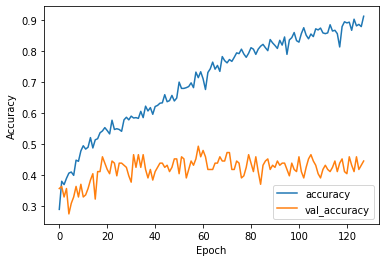

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

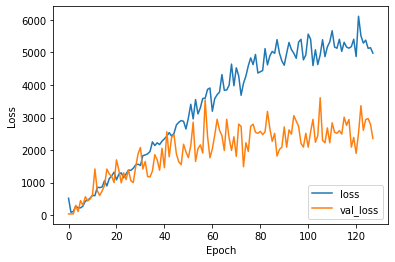

In [24]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [25]:
# test = np.array([test_images[0]])
pred = model.predict(test_images)
true = test_nodelist
# print(pred)
print("Pred")
print((pred * 10).round())
print("True")
print(true * 10)

Pred
[[ 1.  5.  1.  6.  1.  3.  3.]
 [ 1.  5. -1.  4.  5.  2.  4.]
 [ 1.  5.  2. -2.  6.  4.  4.]
 [ 3.  1.  5.  4.  4.  2.  3.]
 [ 4. -0.  1.  6.  5.  3.  2.]
 [ 3.  1.  1.  5.  6.  4.  2.]
 [ 3.  2.  3.  2.  3.  3.  3.]
 [ 2.  2.  4.  6.  2.  1.  4.]
 [ 3.  3.  3.  3.  3.  2.  4.]
 [ 1.  0.  6.  4.  5.  3.  2.]
 [ 2.  3.  4.  1.  4.  3.  3.]
 [ 1.  4.  6.  0.  1.  5.  3.]
 [ 1.  3.  4.  3.  6.  2.  2.]
 [ 3.  0.  1.  5.  5.  3.  3.]
 [ 1.  5.  5. -1.  4.  3.  3.]
 [ 1.  2.  5.  3.  3.  4.  3.]
 [ 3.  2.  2.  3.  5.  2.  3.]
 [ 1.  5.  6.  1.  2.  4.  3.]
 [ 0.  4.  4.  5.  2.  2.  4.]
 [ 4.  2.  5.  3.  4.  2.  1.]
 [ 1.  1.  5.  5.  4.  2.  2.]
 [ 2.  2.  5.  4.  3.  2.  3.]
 [ 3.  1.  3.  3.  7.  1.  3.]
 [ 3.  2.  3.  1.  4.  4.  3.]
 [ 1.  5.  6.  2.  1.  5.  2.]
 [ 1.  4.  6.  1.  1.  4.  4.]
 [ 1.  5.  6.  3.  2.  2.  2.]
 [ 1.  3.  5.  5.  2.  2.  4.]
 [ 1.  0.  6.  4.  5.  2.  3.]
 [ 5.  1.  2.  4.  6.  0.  3.]
 [ 4.  2.  5.  2.  4.  1.  4.]
 [ 1.  2.  6.  6.  1.  1.  4.]
 [ 